# Using SGD on MNIST

# Background

# Imports and data

In [307]:
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *
import torch
import torch.nn as nn
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from scipy.cluster import hierarchy as hc
from treeinterpreter import treeinterpreter as ti

from sklearn import metrics
import feather
import pdpbox.pdp as pdp
from plotnine import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
from contextlib import contextmanager

plt.rcParams["figure.figsize"] = (10, 6)
np.set_printoptions(precision=5)
pd.set_option("display.precision", 5)
%precision 5

# constants #################################################################
PATH = 'data/mnist/'
URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

import pymorton as pm


def morton_indexer(w, h):
    assert w & (w - 1) == 0
    assert h & (h - 1) == 0
    enc = np.zeros(w * h, dtype=np.int)
    dec = np.zeros(w * h, dtype=np.int)
    i = 0
    for r in range(h):
        for c in range(w):
            m = pm.interleave(c, r)
            enc[i] = m
            dec[m] = i
            i += 1
    return enc, dec


def load_mnist(filename):
    ((x, y), (x_valid, y_valid), (x_test, y_test)) = pickle.load(
        gzip.open(filename, 'rb'), encoding='latin-1')
    d = AttrDict(locals())
    # normalization:
    d.mean = d.x.mean()
    d.std = d.x.std()
    d.x = (d.x - d.mean) / d.std
    d.x_valid = (d.x_valid - d.mean) / d.std
    d.x_test = (d.x_test - d.mean) / d.std
    # aliases
    d.x_train = d.x
    d.y_train = d.y
    # format images
    d.x_imgs = d.x_train_imgs = d.x.reshape([-1, 28, 28])
    d.x_valid_imgs = d.x_valid.reshape([-1, 28, 28])
    d.x_test_imgs = d.x_test.reshape([-1, 28, 28])
    # mortonize
    d.enc, d.dec = morton_indexer(32, 32)
    padding = ([0, 0], [2, 2], [2, 2])
    d.mx = np.pad(
        d.x_imgs, padding, mode='edge').reshape(-1, 32 * 32)[:, d.enc]
    d.mx_valid = np.pad(
        d.x_valid_imgs, padding, mode='edge').reshape(-1, 32 * 32)[:, d.enc]
    d_mx_train = np.pad(
        d.x_train_imgs, padding, mode='edge').reshape(-1, 32 * 32)[:, d.enc]
    return d


# defines: ##################################################################
# @contextmanager
# def rf_samples(n='all'):
#     if isinstance(n, int) and n > 0:
#         set_rf_samples(n)
#     try:
#         yield
#     finally:
#         if isinstance(n, int) and n > 0:
#             reset_rf_samples()


# def accuracy(preds, targs):
#     preds = torch.max(preds, dim=1)[1]
#     return (preds==targs).float().mean()

def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()


class AttrDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [147]:
os.makedirs(PATH, exist_ok=True)
get_data(URL + FILENAME, PATH + FILENAME)

In [207]:
data = load_mnist(PATH+FILENAME)
data.x.shape, data.x_valid.shape, data.x_test.shape

((50000, 784), (10000, 784), (10000, 784))

## Normalization

... is a part of `load_mnist`

## Look at the data

### Helper methods

In [5]:
def show(img, title=None):
    plt.imshow(img, cmap='gray')
    if title is not None: plt.title(title)
    plt.show()


def show_idx(data, idx, suffix='valid'):
    xs = data['x_' + suffix + '_imgs']
    ys = data['y_' + suffix]
    show(xs[idx], title='x_{}#{}: {}'.format(suffix, idx, ys[idx]))


def plots(ims, figsize=(12, 6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

### Plots

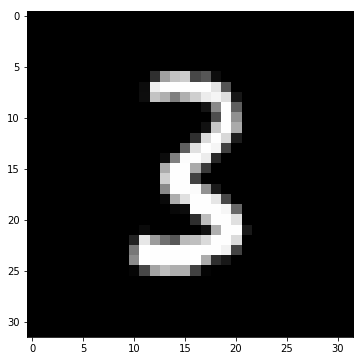

In [211]:
show(data.mx_valid[:, data.dec].reshape(-1, 32, 32)[0])

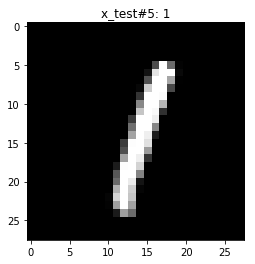

In [6]:
show_idx(data, 5, suffix='test')

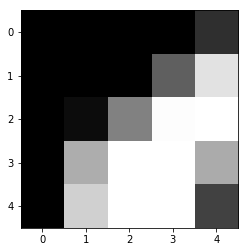

In [7]:
show(data.x_valid_imgs[0,10:15, 10:15])

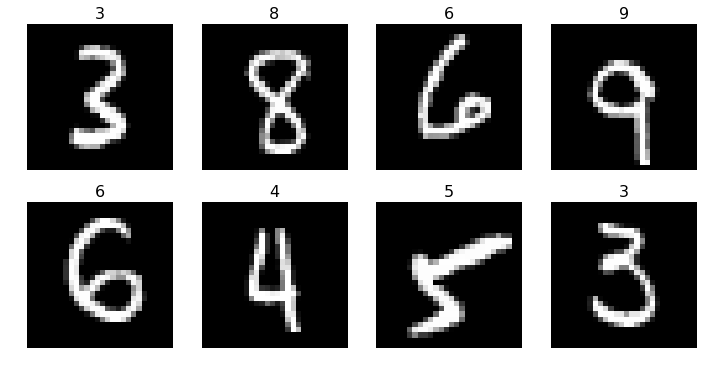

In [8]:
plots(data.x_valid_imgs[:8], titles=data.y_valid[:8])

# Neural Networks

## Functions, parameters, and training

# Neural Net for Logistic Regression in PyTorch

## Loss functions and metrics

In [9]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1 - y) * np.log(1 - p)))

In [10]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

In [11]:
def binary_loss_if(y, p):
    xs = np.zeros(y.shape)
    for i in range(len(xs)):
        if y[i] == 0:
            xs[i] = -np.log(1 - p[i])
        else:
            xs[i] = -np.log(p[i])
    return np.mean(xs)

In [12]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss_if(acts, preds)

0.164252033486018

## Fitting the model

In [14]:
md = ImageClassifierData.from_arrays(PATH, (data.x, data.y),
                                     (data.x_valid, data.y_valid))
loss = nn.NLLLoss()
metrics = [accuracy]

In [216]:
net_0 = nn.Sequential(nn.Linear(28 * 28, 10), nn.LogSoftmax())
opt_0 = optim.Adam(net_0.parameters())
# NOTE: Loss is a 'criterion' in Torch
fit(net_0, md, n_epochs=1, crit=loss, opt=opt_0, metrics=metrics)
preds = predict(net_0, md.val_dl)

epoch      trn_loss   val_loss   accuracy                     
    0      0.341418   0.287234   0.9177    



In [275]:
# with morton
md_m = ImageClassifierData.from_arrays(PATH, (data.mx, data.y),
                                       (data.mx_valid, data.y_valid))
loss = nn.NLLLoss()
metrics = [accuracy]
net_m = nn.Sequential(
    nn.Linear(32 * 32, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax())
opt_m = optim.Adam(net_m.parameters())
fit(net_m, md_m, n_epochs=1, crit=loss, opt=opt_m, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.186661   0.177169   0.9485    



[array([0.17717]), 0.9485]

In [17]:
preds.shape

(10000, 10)

In [18]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [19]:
np.mean(preds.argmax(axis=1) == data.y_valid)

0.9212

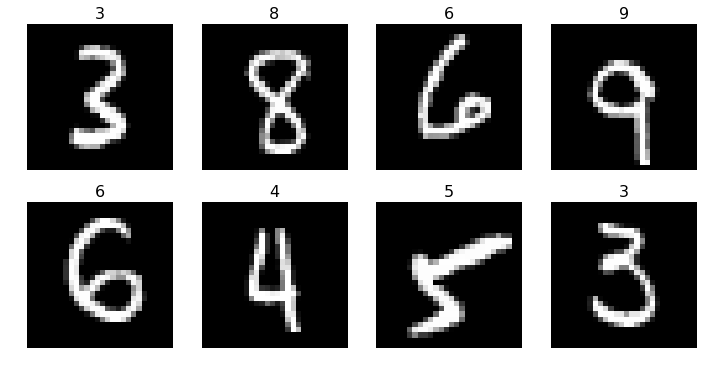

In [20]:
plots(data.x_valid_imgs[:8], titles=preds.argmax(1)[:8])

# Defining Logistic Regression Ourselves

In [56]:
def get_weights(*dims):
    return nn.Parameter(
        torch.randn(dims) / dims[0])  # Kaiming He initialization


def softmax(x):
    return torch.exp(x) / (torch.exp(x).sum(dim=1)[:, None])


class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28 * 28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)  # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)  # torch's reshape
        x = (x @ self.l1_w) + self.l1_b
        x = torch.log(softmax(x))  # torchy LogSoftmax
        return x

In [218]:
net2 = LogReg()
opt = optim.Adam(net2.parameters())
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.326476   0.299335   0.9148    



[array([0.29933]), 0.9148]

In [242]:
xmb, ymb = next(iter(md.trn_dl))
vxmb = Variable(xmb)
preds = net2(vxmb).exp()

In [284]:
_, ps = preds.max(dim=1)
ps[:3], ymb[:3]

(Variable containing:
  8
  7
  7
 [torch.LongTensor of size 3], 
  8
  7
  7
 [torch.LongTensor of size 3])

# Aside about Broadcasting and Matrix Multiplication

##  Element-wise operations

In [293]:
a = T([10, 6, -4])
b = T([2, 8, 7])
an = np.array([10, 6, -4])
bn = np.array([2, 8, 7])

In [287]:
a + b


 12
 14
  3
[torch.LongTensor of size 3]

In [288]:
a - b


  8
 -2
-11
[torch.LongTensor of size 3]

In [298]:
a @ b, an @ bn

(40, 40)

## Broadcasting

In [299]:
c = np.array([10, 20, 30])

In [300]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [306]:
c[None] * c[:, None]

array([[100, 200, 300],
       [200, 400, 600],
       [300, 600, 900]])

# Writing Our Own Training Loop

In [314]:
md = ImageClassifierData.from_arrays(PATH, (data.x, data.y),
                                     (data.x_valid, data.y_valid))
net3 = LogReg()
opt3 = optim.Adam(net3.parameters(), lr=1e-3)
loss = nn.NLLLoss()
metrics = [accuracy]
fit(net3, md, n_epochs=1, crit=loss, opt=opt3, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.329762   0.289765   0.9183    



[array([0.28977]), 0.9183]

In [ ]:
md = ImageClassifierData.from_arrays(PATH, (data.x, data.y),
                                     (data.x_valid, data.y_valid))

In [408]:
%xdel net4


In [433]:
def myfit(md, lr=1e-2, epcount=1):
    def score(nnet, x, y):
        y_pred = to_np(nnet(Variable(x)))
        return np.sum(y_pred.argmax(axis=1) == to_np(y)) / len(y_pred)

    net = LogReg()
    opt = optim.SGD(net.parameters(), lr=lr)
    loss = nn.NLLLoss()
    metrics = [accuracy]
    losses = []
    for ep in range(epcount):
        print('ep', ep + 1)
        t = 0
        for xt, yt in md.trn_dl:
            y_pred = net(Variable(xt))
            l = loss(y_pred, Variable(yt))
            losses.append(l)
            t += 1
            if t % 10 == 0:
                print('.', end='')
            opt.zero_grad()
            l.backward()
            opt.step()
        accuracies = [score(net, *xy) for xy in md.val_dl]
        print()
        print('%0.5f' % np.mean(accuracies))
    return net, accuracies, losses

In [439]:
 myfit(md);

ep 1
..............................................................................
0.90943


# Stochastic Gradient Descent (SGD)

In [441]:
def myfit_opt(md, lr=1e-2, epcount=1):
    def score(nnet, x, y):
        y_pred = to_np(nnet(Variable(x)))
        return np.sum(y_pred.argmax(axis=1) == to_np(y)) / len(y_pred)

    net = LogReg()
    loss = nn.NLLLoss()
    metrics = [accuracy]
    losses = []
    w, b = net.l1_w, net.l1_b
    for ep in range(epcount):
        print('ep', ep + 1)
        t = 0
        for xt, yt in md.trn_dl:
            y_pred = net(Variable(xt))
            l = loss(y_pred, Variable(yt))
            losses.append(l)
            t += 1
            if t % 10 == 0:
                print('.', end='')

            # backward pass: compute gradient wrt model parameters
            l.backward()

            w.data -= w.grad.data * lr
            b.data -= b.grad.data * lr

            # NOTE: xxx_ underscore in pytorch means `inplace`
            w.grad.data.zero_()
            b.grad.data.zero_()

        accuracies = [score(net, *xy) for xy in md.val_dl]
        print()
        print('%0.5f' % np.mean(accuracies))
    return net, accuracies, losses

In [442]:
myfit_opt(md);

ep 1
..............................................................................
0.90804


# Fitting the model

In [468]:
net = nn.Sequential(
    nn.Linear(28 * 28, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(),
    nn.Linear(100, 10), nn.LogSoftmax())
opt = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-3)
loss = nn.NLLLoss()
fit(net, md, n_epochs=5, crit=nn.NLLLoss(), opt=opt, metrics=[accuracy])
# Learning rate annealing:
set_lrs(opt, 1e-2)
fit(net, md, n_epochs=3, crit=nn.NLLLoss(), opt=opt, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                     
    0      0.193136   0.165346   0.9531    
    1      0.120785   0.111747   0.9681                       
    2      0.08093    0.092411   0.9739                        
    3      0.07788    0.085977   0.9752                        
    4      0.058111   0.088635   0.9737                        



epoch      trn_loss   val_loss   accuracy                      
    0      0.050727   0.074681   0.9792    
    1      0.044207   0.075302   0.9788                        
    2      0.046645   0.078144   0.9776                        



[array([0.07814]), 0.9776]

*Regularization:*
```
L1 = a*|W|
L2 = a*W^2
where a is regularization parameter
```

mm